In [711]:
import pandas as pd
import numpy as np 
import os
import plotly.express as px
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from matplotlib import pyplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import random

# For investigating timeseries data
from sklearn import preprocessing
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose

# For modeling
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost
from prophet import Prophet

### Loading Data

In [712]:
# Reading Data
base_path =  os.getcwd()
file_name = 'Traffic_Data.xlsx'
total_path = base_path + '//Data//' 
df = pd.read_excel(total_path + file_name, sheet_name='Sheet1')
df.head(10)


,State,Region,STATIONS,CMILES,PMILES,Month,Month_2,Year,Date
0,Connecticut,Northeast,14,2546,2432,November,11,2023,2023-11-01
1,Maine,Northeast,130,1177,1148,November,11,2023,2023-11-01
2,Massachusetts,Northeast,227,5148,5013,November,11,2023,2023-11-01
3,New Hampshire,Northeast,150,1062,1034,November,11,2023,2023-11-01
4,New Jersey,Northeast,73,6569,6339,November,11,2023,2023-11-01
5,New York,Northeast,110,9144,8825,November,11,2023,2023-11-01
6,Pennsylvania,Northeast,57,8610,8408,November,11,2023,2023-11-01
7,Rhode Island,Northeast,26,661,659,November,11,2023,2023-11-01
8,Vermont,Northeast,35,543,531,November,11,2023,2023-11-01
9,Delaware,South Atlantic,0,923,900,November,11,2023,2023-11-01


### Plotting all Data

In [713]:
fig = px.scatter(df, x="Date", y="CMILES", color="State", facet_col="Region", 
                 facet_col_wrap=2, title = 'US Traffic by over Time Region and State')
fig.show()

In [714]:
# Filtering for just one state
df = df[df['State'] == 'Oregon']
df = df.sort_values(by = ['Date']).reset_index()
df.head(10)

,index,State,Region,STATIONS,CMILES,PMILES,Month,Month_2,Year,Date
0,3056,Oregon,West,153,2823,2769,January,1,2019,2019-01-01
1,3005,Oregon,West,143,2393,2566,February,2,2019,2019-02-01
2,2954,Oregon,West,153,3088,3104,March,3,2019,2019-03-01
3,2903,Oregon,West,152,3034,2990,April,4,2019,2019-04-01
4,2852,Oregon,West,147,3303,3295,May,5,2019,2019-05-01
5,2801,Oregon,West,154,3334,3318,June,6,2019,2019-06-01
6,2750,Oregon,West,153,3547,3527,July,7,2019,2019-07-01
7,2699,Oregon,West,152,3587,3541,August,8,2019,2019-08-01
8,2648,Oregon,West,155,3246,3216,September,9,2019,2019-09-01
9,2597,Oregon,West,157,3241,3185,October,10,2019,2019-10-01


### Plotting Data

In [715]:
fig = px.scatter(df.reindex(), x="Date", y="CMILES", trendline="lowess",trendline_options=dict(frac=0.1),
                  title = 'Miles Driven by Time - Oregon')
fig.show()

In [716]:
# Replacing outlier January 2023 value
mean_val = df[(df['Month'] == 'January') &
              (df['Year'] != 2023)]['CMILES'].mean()
df['CMILES'] = np.where(df['CMILES'] <1000, mean_val, df['CMILES'])

fig = px.scatter(df, x="Date", y="CMILES", trendline="lowess",trendline_options=dict(frac=0.1),
                 title = 'Miles Driven by Time - Oregon - Outlier adjusted')
fig.show()

### Seasonal Decomposition

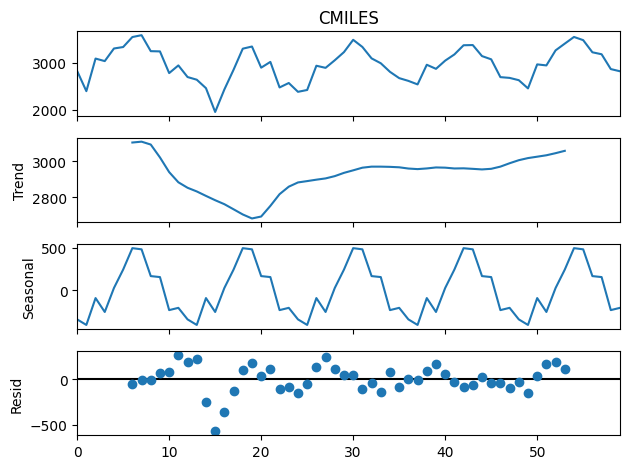

In [717]:
result = seasonal_decompose(df['CMILES'], model='additive', period=12)
result.plot()
pyplot.show()

### Defining Functions
There are several functions we need for this problem:

(1) convert_to_supervised: offsets are dataset to convert a one dimensional time series of length x1 into x2 by x2-n where n is the amount of timesteps we want to use to predict a given future values

(2) forecast: Predicts the next values from an input dataset

(3) stepwise_prediction: steps through a dataset one point at a time, calling the forecast method to predict the next point, iterating forward in the dataset until we are at the end

(4) concat_predictions: concats the predicted dataframe with the original dataframe so we can visualize and measure the accuracy of our model

(5) graph_forecast: generates a lineplot of predicted versus actual values and displays the MAPE in the title

(6) crosscorr: Offsets dataset by x spaces for use in calculating pearson correlation coefficients between lagged variables

In [718]:
# Defining function to convert time series problem into supervised learning problem
def convert_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 
 df = pd.DataFrame(data)
 cols = list()
 # Training sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    
 # Forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))

 # Concatenating columns together
 agg = pd.concat(cols, axis=1)
 
 # drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values


# Function to split into test/train set based on time
def train_test_split(data, n_test):

   '''Takes input dataframe and splits by time'''
   train = data.loc[:len(data) - n_test -1]
   test = data.tail(n_test)

   return train, test

# Fit xgboost model based on histroric data and making prediction for next timestamp
def forecast(train, testX, parameters):
 

   x_train, y_train = train.drop(columns = ['t']), train['t']
   # fitting model
   model = xgboost.XGBRegressor(objective='reg:squarederror', 
                              max_depth = parameters['max_depth'],
                              n_estimators = parameters['n_estimators'],
                              reg_lambda = parameters['reg_lambda'])
   model.fit(x_train, y_train)

   # making a prediction
   y_predicted = model.predict(testX)
   return y_predicted[0]


def stepwise_prediction(data, prediction_count, parameters):
 
 '''Iterates through timeseries dataframe, fitting a new model for data up to
 time t and making prediction for time t+1'''
 
 predictions = list()

 # Iterating through dataset one timestep at a time
 for i in range(prediction_count):
   
   steps_back = prediction_count-i
   # Creating test/train sets with time based split
   train, test = train_test_split(data, steps_back)

   # Creating new test and train dataset for each timestep
   testX, testy = test.drop(columns = ['t']), test['t']
   # Fitting model and making prediction for next step
   y_pred = forecast(train, testX, parameters)
   # store forecast in list of predictions
   predictions.append(y_pred)

 return  predictions

def concat_predictions(df, y_pred, prediction_dates):

    '''Takes base dataframe + lists containing predicted dates and values
    and returns a merged dataset with a predicted/actual column. Dataframe
    can be used for visualization'''
    # Creating dataframe for comparing predicted/actual values
    df_comparison = df[['CMILES', 'Date']]
    df_comparison['Method'] = 'Actual'

    # Converting xgboost predictions to dataframe
    xgboost_dict = {'CMILES': y_pred,
                    'Date': prediction_dates,
                    'Method': 'xgboost'}
    xgboost_df = pd.DataFrame.from_dict(xgboost_dict)

    # Appending predictions to comparison dataframe   
    df_comparison = pd.concat([df_comparison, xgboost_df], ignore_index=True)

    return df_comparison


def graph_forecast(df_comparison, prediction_count):

    '''Takes Dataframe containing both predicted + actual values, calculates the MAPE,
    and displays a lineplot of the predicted versus actual values'''

    y_pred = df_comparison[df_comparison['Method']=='xgboost'].sort_values(by = ['Date'])['CMILES'].to_list()
    y_actual = df_comparison[df_comparison['Method']=='Actual'].sort_values(by = ['Date'])[-prediction_count:]['CMILES'].to_list()
    print(y_pred)
    print(y_actual)
    # Calculating MAPE for xgboost
    xgboost_mape = round(mean_absolute_percentage_error(y_pred, y_actual),3)

    compare_fig = px.line(df_comparison, x = 'Date', y = 'CMILES', color='Method',
                        title = 'Predicted vs Actual Traffic, MAPE: {mape}'.format(mape = xgboost_mape))
    compare_fig.show()


def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

def rename_dataframe_supervised(data_df, state_name = ""):

   '''Takes a dataframe with column names 1-x, relabes them as t through t - x
   and returns. Used to illustrate how the timeseries to supervised conversion works'''

   # Renaming columns in dataframe
   max_col = max(data_df.columns.astype(int))
   for col in data_df.columns:
      if int(col) == max_col:
         data_df.rename(columns={col:"t"},inplace=True)
      else:
         data_df.rename(columns={col:"{state}t - {val}".format(state = state_name,val = max_col-col)},inplace=True)
   return data_df



### Converting from TimeSeries to Supervised Problem

Below dataframe with indices rather than values shows how we can convert our one dimensional timeseries dataset into a two dimensional supervised learning problem. Our dependent variable is t and the independent variables are t-1 through t-x. In the below example we can see that for our first observation we are modeling t(value in index 6 of the original series) as dependent on the values in index 0-5 of the original series. For the second observation we then shift our window one datapoint further and continue this approach until we reach the end of the series.

In [719]:
n_in_initial = 6
indices = df['CMILES'].index
# Transforming to time series                                                                                                                                                       
data = convert_to_supervised(indices, n_in=n_in_initial)
data_df = pd.DataFrame(data)
data_df = rename_dataframe_supervised(data_df)
data_df.head()

,t - 6,t - 5,t - 4,t - 3,t - 2,t - 1,t
0,0.0,1.0,2.0,3.0,4.0,5.0,6.0
1,1.0,2.0,3.0,4.0,5.0,6.0,7.0
2,2.0,3.0,4.0,5.0,6.0,7.0,8.0
3,3.0,4.0,5.0,6.0,7.0,8.0,9.0
4,4.0,5.0,6.0,7.0,8.0,9.0,10.0


In [720]:
values = df['CMILES'].values
# Transforming to time series                                                                                                                                                       
data = convert_to_supervised(values, n_in=n_in_initial)
# Converting to dataframe
data = rename_dataframe_supervised(pd.DataFrame(data))
data.head(10)

,t - 6,t - 5,t - 4,t - 3,t - 2,t - 1,t
0,2823.0,2393.0,3088.0,3034.0,3303.0,3334.0,3547.0
1,2393.0,3088.0,3034.0,3303.0,3334.0,3547.0,3587.0
2,3088.0,3034.0,3303.0,3334.0,3547.0,3587.0,3246.0
3,3034.0,3303.0,3334.0,3547.0,3587.0,3246.0,3241.0
4,3303.0,3334.0,3547.0,3587.0,3246.0,3241.0,2778.0
5,3334.0,3547.0,3587.0,3246.0,3241.0,2778.0,2942.0
6,3547.0,3587.0,3246.0,3241.0,2778.0,2942.0,2694.0
7,3587.0,3246.0,3241.0,2778.0,2942.0,2694.0,2637.0
8,3246.0,3241.0,2778.0,2942.0,2694.0,2637.0,2457.0
9,3241.0,2778.0,2942.0,2694.0,2637.0,2457.0,1949.0


### Fitting Model

In [721]:
# Defining default parameters
default_parameters = {'max_depth': 4,
        'reg_lambda' : 1,
        'n_estimators': 200,
        'seed': 42
    }

# Setting test dataset size
prediction_count = 26
prediction_dates = df['Date'].sort_values()[-prediction_count:]
# Making prediction with Xgboost
y_pred = stepwise_prediction(data, prediction_count, default_parameters)
print(y_pred)

[2763.2905, 2772.0715, 2518.1936, 2399.6306, 2170.4338, 2716.8296, 3015.044, 3008.0996, 3256.9426, 3313.9255, 3101.9749, 3040.401, 2863.4333, 2828.2454, 2612.1567, 2636.365, 2603.5344, 2903.065, 3030.851, 3328.692, 3374.9207, 3495.8425, 3208.913, 3090.7666, 2806.0842, 2832.8179]


### Analyzing Results

In [722]:
# Joining Actual vs predicte values
df_comparison = concat_predictions(df, y_pred, prediction_dates)

C:\Users\seelc\AppData\Local\Temp\ipykernel_22604\1879470128.py:79: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Graphing Actual vs Predicted Values

In [723]:
# Generating graph of actual vs predicted values
graph_forecast(df_comparison, prediction_count)

[2763.29052734375, 2772.071533203125, 2518.193603515625, 2399.630615234375, 2170.433837890625, 2716.82958984375, 3015.0439453125, 3008.099609375, 3256.942626953125, 3313.925537109375, 3101.974853515625, 3040.40087890625, 2863.433349609375, 2828.245361328125, 2612.15673828125, 2636.364990234375, 2603.534423828125, 2903.06494140625, 3030.85107421875, 3328.69189453125, 3374.920654296875, 3495.842529296875, 3208.9130859375, 3090.7666015625, 2806.084228515625, 2832.81787109375]
[2805.0, 2671.0, 2612.0, 2537.0, 2956.0, 2869.0, 3044.0, 3176.0, 3372.0, 3376.0, 3141.0, 3072.0, 2692.0, 2676.0, 2627.0, 2452.0, 2964.0, 2942.0, 3263.0, 3407.0, 3549.0, 3481.0, 3222.0, 3180.0, 2864.0, 2817.0]


### Varying Training Set

Can perform two rounds of tuning, 1 to determine how many previous timepoints to use for training and one for standard XGboost hyperparameters.

In [724]:
timesteps_back = range(1,24)
steps_back, score = [], []
for steps in timesteps_back:

    # Creating dataset that goes x steps back for each observation
    values = df['CMILES'].values                                                                                                                                                   
    data = convert_to_supervised(values, n_in=steps)
    data = rename_dataframe_supervised(pd.DataFrame(data))

    # Making predictions based on dataset
    prediction_dates = df['Date'].sort_values()[-prediction_count:]
    y_pred = stepwise_prediction(data, prediction_count, default_parameters)

    # Calculating MAPE for dataset
    xgboost_mape = round(mean_absolute_percentage_error(y_pred, 
                                              df.sort_values(by = ['Date'])[-prediction_count:]['CMILES']),3)
    steps_back.append(steps)
    score.append(xgboost_mape)

In [725]:
# Converting scoring to dataframe and displaying
score_df = pd.DataFrame.from_dict({'Timesteps Back': steps_back, 'MAPE': score}).sort_values(by = ['MAPE']).reset_index()
score_df.head(10)
n_in_best = score_df['Timesteps Back'][0]

In [726]:
time_plot = px.line(score_df.sort_values(by=['Timesteps Back']).reset_index(), 
                    x = 'Timesteps Back', y = 'MAPE', 
                       title = 'Model Performance versus Timeperiod for Training')
time_plot.show()

### Hyperparameter Tuning

Now we'll perform hyperparameter tuning to determine which set of parameters results in the smallest MAPE.

In this case we'll be evaluating performance on a train set first, select the best model, and than evaluate on the test set. This will allow us to avoid implementing a stepwise prediction method during hyperparameter tuning.

In [727]:
# splitting into X, Y for training
X_train, y_train = data.drop(columns = ['t']), data['t']


# Defining parameters to search over
parameters={'max_depth': range(3,10),
        'reg_lambda' : [0.2, 0.4, 0.6, 0.8, 1],
        'n_estimators': range(200,1000, 100),
        'seed': [42]
    }

# Create the XGBoost model object
xgb_model = xgboost.XGBRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, parameters, cv=3, scoring='neg_mean_absolute_percentage_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Printing results
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': 4, 'n_estimators': 200, 'reg_lambda': 0.2, 'seed': 42}
Best score:  -0.04327156817394396


### Refitting Best Model and Graphing Results

In [728]:
#values = df['CMILES'].values                                                                                                                                                   
data = convert_to_supervised(values, n_in=n_in_best)
# Converting to dataframe
data = rename_dataframe_supervised(pd.DataFrame(data))

best_params = grid_search.best_params_
prediction_dates = df['Date'].sort_values()[-prediction_count:]
# Making prediction with Xgboost
y_pred_best = stepwise_prediction(data, prediction_count, best_params)
# Creating comparison dataset
df_comparison = concat_predictions(df, y_pred_best, prediction_dates)

C:\Users\seelc\AppData\Local\Temp\ipykernel_22604\1879470128.py:79: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [729]:
graph_forecast(df_comparison, prediction_count)

[2772.46826171875, 2627.852294921875, 2615.293701171875, 2526.888916015625, 2820.9189453125, 3004.200927734375, 2955.883056640625, 3118.51171875, 3353.818115234375, 3328.258544921875, 2898.512451171875, 2915.338134765625, 2773.489501953125, 2569.261962890625, 2646.21728515625, 2601.277099609375, 2885.31689453125, 2958.269775390625, 3045.00537109375, 3236.279296875, 3372.414306640625, 3310.23779296875, 3112.741455078125, 3048.3271484375, 2753.782958984375, 2739.550537109375]
[2805.0, 2671.0, 2612.0, 2537.0, 2956.0, 2869.0, 3044.0, 3176.0, 3372.0, 3376.0, 3141.0, 3072.0, 2692.0, 2676.0, 2627.0, 2452.0, 2964.0, 2942.0, 3263.0, 3407.0, 3549.0, 3481.0, 3222.0, 3180.0, 2864.0, 2817.0]


### Adding Additional Variables

Now we have a model predicting the next months traffic in oregon based on historical data but we also have data for other states in our original dataset, we can also try and take advantage of this additional data to build a better performing model

In [730]:
df_all = pd.read_excel(total_path + file_name, sheet_name='Sheet1')
df_all = df_all[df_all['Region'] =='West'].sort_values(by = ['Date'])
df_all.head(10)

,State,Region,STATIONS,CMILES,PMILES,Month,Month_2,Year,Date
3059,Wyoming,West,120,662,653,January,1,2019,2019-01-01
3047,Alaska,West,90,362,355,January,1,2019,2019-01-01
3048,Arizona,West,138,5798,5717,January,1,2019,2019-01-01
3049,California,West,154,25741,25643,January,1,2019,2019-01-01
3050,Colorado,West,102,4705,4740,January,1,2019,2019-01-01
3051,Hawaii,West,58,964,881,January,1,2019,2019-01-01
3058,Washington,West,130,4586,4383,January,1,2019,2019-01-01
3053,Montana,West,92,783,755,January,1,2019,2019-01-01
3054,Nevada,West,81,2172,2172,January,1,2019,2019-01-01
3055,New Mexico,West,58,2340,2339,January,1,2019,2019-01-01


In [731]:
# Cleaning outliers
mean_val_wyoming = df_all[(df_all['Month'] == 'January') &
                      (df_all['State'] == 'Wyoming') &
                      (df_all['Year'] != 2023)]['CMILES'].mean()

mean_val_oregon = df_all[(df_all['Month'] == 'January') &
                      (df_all['State']== 'Oregon') &
                      (df_all['Year'] != 2023)]['CMILES'].mean()

df_all['CMILES'] = np.where((df_all['CMILES'] <1000) & (df_all['State']== 'Oregon'), mean_val_oregon, df_all['CMILES'])
df_all['CMILES'] = np.where((df_all['CMILES'] <1000) & (df_all['State']== 'Wyoming'), mean_val_wyoming, df_all['CMILES'])

In [732]:
# Now were going to calculate a correlation matrix between lag 1-6
corr_matrix = []
impactful_vars = []
corr_dict = {}
lags = [1,2,3,5,6]
western_states = df_all['State'].drop_duplicates().to_list()
for state in western_states:
    var_cor = []
    x = df_all[df_all['State']== state].reset_index()['CMILES']
    y = df_all[df_all['State']=='Oregon'].reset_index()['CMILES']
    # Calculating correlation between two states traffics at each lag value
    for lag in lags:
        var_cor.append(round(crosscorr(x,y, lag = lag),2))

    # Adding results
    corr_matrix.append(var_cor)
    impactful_vars.append(state)
    corr_dict[state] = var_cor

In [733]:
fig = px.imshow(corr_matrix,
                labels=dict(x="Lag", y="Variable", color="Pearson Correlation"),
                x=lags,
                y=impactful_vars,
                text_auto=True,
                title= "Traffic Correlation Between Western States and Oregon"
               )
fig.show()

Can see we have the strongest correlation between Wyoming and Oregon, will build a new model incorporating wyomings data

In [734]:
# Filtering for just oregon + Wyoming
df_multi = df_all[df_all['State'].isin(['Oregon', 'Idaho'])]

# Returning values CMILE values for both states
oregon_vals = df_multi[df_multi['State'] == 'Oregon']['CMILES'].values
wyoming_vales = df_multi[df_multi['State'] == 'Idaho']['CMILES'].values

# Transforming to time series                                                                                                                                                       
data_oregon = convert_to_supervised(oregon_vals, n_in=n_in_best)
data_wyoming = convert_to_supervised(wyoming_vales, n_in=6)

# converting to dataframes
data_oregon_df = pd.DataFrame(data_oregon)
data_wyoming_df = pd.DataFrame(data_wyoming)

# Relabeling dataframes
data_oregon_df = rename_dataframe_supervised(data_oregon_df, "Oregon")
data_wyoming_df = rename_dataframe_supervised(data_wyoming_df, 'Idaho').drop(columns = ['t'])

# Joining together
combined_df = pd.merge(data_oregon_df, data_wyoming_df , left_index=True, right_index=True)
combined_df.head(10)



,Oregont - 16,Oregont - 15,Oregont - 14,Oregont - 13,Oregont - 12,Oregont - 11,Oregont - 10,Oregont - 9,Oregont - 8,Oregont - 7,...,Oregont - 3,Oregont - 2,Oregont - 1,t,Idahot - 6,Idahot - 5,Idahot - 4,Idahot - 3,Idahot - 2,Idahot - 1
0,2823.0,2393.0,3088.0,3034.0,3303.0,3334.0,3547.0,3587.0,3246.0,3241.0,...,2637.0,2457.0,1949.0,2429.0,1301.0,1225.0,1436.0,1508.0,1554.0,1630.0
1,2393.0,3088.0,3034.0,3303.0,3334.0,3547.0,3587.0,3246.0,3241.0,2778.0,...,2457.0,1949.0,2429.0,2850.0,1225.0,1436.0,1508.0,1554.0,1630.0,1780.0
2,3088.0,3034.0,3303.0,3334.0,3547.0,3587.0,3246.0,3241.0,2778.0,2942.0,...,1949.0,2429.0,2850.0,3299.0,1436.0,1508.0,1554.0,1630.0,1780.0,1714.0
3,3034.0,3303.0,3334.0,3547.0,3587.0,3246.0,3241.0,2778.0,2942.0,2694.0,...,2429.0,2850.0,3299.0,3345.0,1508.0,1554.0,1630.0,1780.0,1714.0,1599.0
4,3303.0,3334.0,3547.0,3587.0,3246.0,3241.0,2778.0,2942.0,2694.0,2637.0,...,2850.0,3299.0,3345.0,2894.0,1554.0,1630.0,1780.0,1714.0,1599.0,1590.0
5,3334.0,3547.0,3587.0,3246.0,3241.0,2778.0,2942.0,2694.0,2637.0,2457.0,...,3299.0,3345.0,2894.0,3017.0,1630.0,1780.0,1714.0,1599.0,1590.0,1383.0
6,3547.0,3587.0,3246.0,3241.0,2778.0,2942.0,2694.0,2637.0,2457.0,1949.0,...,3345.0,2894.0,3017.0,2472.0,1780.0,1714.0,1599.0,1590.0,1383.0,1372.0
7,3587.0,3246.0,3241.0,2778.0,2942.0,2694.0,2637.0,2457.0,1949.0,2429.0,...,2894.0,3017.0,2472.0,2567.0,1714.0,1599.0,1590.0,1383.0,1372.0,1298.0
8,3246.0,3241.0,2778.0,2942.0,2694.0,2637.0,2457.0,1949.0,2429.0,2850.0,...,3017.0,2472.0,2567.0,2379.0,1599.0,1590.0,1383.0,1372.0,1298.0,1317.0
9,3241.0,2778.0,2942.0,2694.0,2637.0,2457.0,1949.0,2429.0,2850.0,3299.0,...,2472.0,2567.0,2379.0,2418.0,1590.0,1383.0,1372.0,1298.0,1317.0,1191.0


In [735]:

y_pred_combined = stepwise_prediction(combined_df, prediction_count, best_params)
# Creating comparison dataset
df_comparison = concat_predictions(df, y_pred_combined, prediction_dates)

C:\Users\seelc\AppData\Local\Temp\ipykernel_22604\1879470128.py:79: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [736]:
graph_forecast(df_comparison, prediction_count)

[2771.396240234375, 2626.739501953125, 2621.6083984375, 2567.544921875, 2782.585693359375, 3016.468994140625, 2961.063720703125, 3171.5341796875, 3348.58154296875, 3338.54931640625, 2896.710205078125, 2927.6142578125, 2762.66162109375, 2589.621826171875, 2630.812255859375, 2599.476318359375, 2943.53564453125, 2979.587158203125, 3053.625, 3219.787109375, 3355.279296875, 3382.14697265625, 3143.286865234375, 3128.5, 2688.442626953125, 2822.686279296875]
[2805.0, 2671.0, 2612.0, 2537.0, 2956.0, 2869.0, 3044.0, 3176.0, 3372.0, 3376.0, 3141.0, 3072.0, 2692.0, 2676.0, 2627.0, 2452.0, 2964.0, 2942.0, 3263.0, 3407.0, 3549.0, 3481.0, 3222.0, 3180.0, 2864.0, 2817.0]


### Comparing XGboost with Prophet

In [737]:
prophet_df = df[['CMILES', 'Date']].copy()
prophet_df = prophet_df.rename(columns= {'CMILES':'y',
                                       'Date':'ds'}).reset_index().drop(columns=['index'])
prophet_df.head(10)

,y,ds
0,2823.0,2019-01-01
1,2393.0,2019-02-01
2,3088.0,2019-03-01
3,3034.0,2019-04-01
4,3303.0,2019-05-01
5,3334.0,2019-06-01
6,3547.0,2019-07-01
7,3587.0,2019-08-01
8,3246.0,2019-09-01
9,3241.0,2019-10-01


In [738]:
train, test = prophet_df[:len(prophet_df['y'])-prediction_count], prophet_df[-prediction_count:]
prophet_model = Prophet()
prophet_model.fit(train)
print(test)

15:41:36 - cmdstanpy - INFO - Chain [1] start processing
15:41:36 - cmdstanpy - INFO - Chain [1] done processing


         y         ds
34  2805.0 2021-11-01
35  2671.0 2021-12-01
36  2612.0 2022-01-01
37  2537.0 2022-02-01
38  2956.0 2022-03-01
39  2869.0 2022-04-01
40  3044.0 2022-05-01
41  3176.0 2022-06-01
42  3372.0 2022-07-01
43  3376.0 2022-08-01
44  3141.0 2022-09-01
45  3072.0 2022-10-01
46  2692.0 2022-11-01
47  2676.0 2022-12-01
48  2627.0 2023-01-01
49  2452.0 2023-02-01
50  2964.0 2023-03-01
51  2942.0 2023-04-01
52  3263.0 2023-05-01
53  3407.0 2023-06-01
54  3549.0 2023-07-01
55  3481.0 2023-08-01
56  3222.0 2023-09-01
57  3180.0 2023-10-01
58  2864.0 2023-11-01
59  2817.0 2023-12-01


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



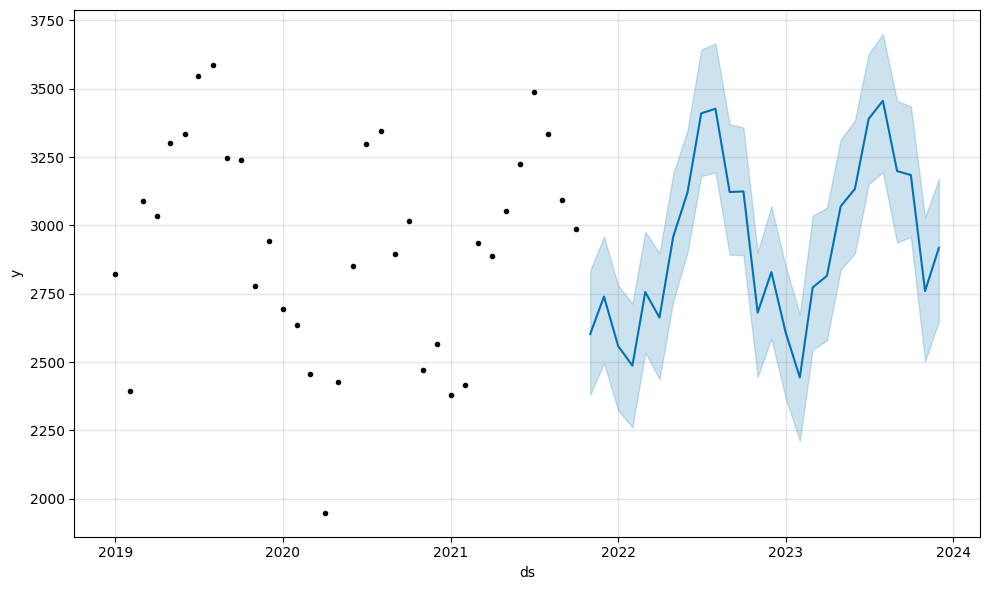

In [739]:
forecast = prophet_model.predict(test)
fig1 = prophet_model.plot(forecast)

### Comparing XGboost and Prophet

In [740]:
y_pred_prophet = forecast['yhat'].values

# Converting prophet predictions to dataframe
prophet_dict = {'CMILES': y_pred_prophet,
                'Date': prediction_dates,
                'Method': 'Prophet'}
prophet_df = pd.DataFrame.from_dict(prophet_dict)

# Appending predictions to comparison dataframe   
df_comparison = pd.concat([df_comparison, prophet_df], ignore_index=True)

In [741]:
# Calculating MAPE for xprophet
prophet_mape = round(mean_absolute_percentage_error(y_pred_prophet, 
                                              df.sort_values(by = ['Date'])[-prediction_count:]['CMILES']),3)

compare_fig = px.line(df_comparison, x = 'Date', y = 'CMILES', color='Method',
                      title = 'Predicted vs Actual Traffic, XGboost MAPE: {mape_g} , Prophet MAPE: {mape_p} '.format(mape_g = xgboost_mape, mape_p = prophet_mape))
compare_fig.show()